# FitsYou: An AI-based, in-store clothing recommendation system.
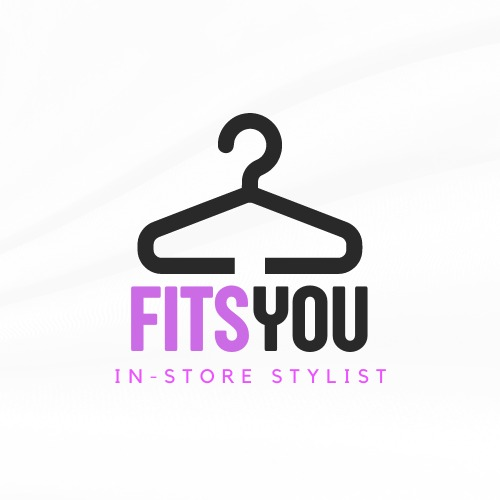

# Installation

In [ ]:
!pip install ultralytics

In [ ]:
# clone repository
!git clone https://github.com/lastdefiance20/TryYours-Virtual-Try-On

# install dependencies
!pip install tensorboardX av torchgeometry flask flask-ngrok iglovikov_helper_functions cloths_segmentation albumentations
!pip install scipy==1.8.0
# install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install opendatasets


In [ ]:
import json
%cd /content
# Assuming you have the following variables with the information
username = "halabkhidhr"
key = "bdf41b0af1ba231e2a7ab1e4720828c9"


# Create a dictionary with the information
data = {
    'username': username,
    'key': key,

}

# Define the JSON file path
json_file_path = '/content/kaggle.json'  # Replace with your desired JSON file path

# Write the dictionary to the JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Information saved to {json_file_path}.")


In [ ]:
import opendatasets as od


od.download(
    "https://www.kaggle.com/datasets/rkuo2000/viton-plus")

In [ ]:
!pip install --upgrade --no-cache-dir gdown
%cd /content/TryYours-Virtual-Try-On
%cd HR-VITON-main
!gdown https://drive.google.com/u/0/uc?id=1T5_YDUhYSSKPC_nZMk2NeC-XXUFoYeNy&export=download
!gdown https://drive.google.com/u/0/uc?id=1XJTCdRBOPVgVTmqzhVGFAgMm2NLkw5uQ&export=download
%cd ../

%cd Graphonomy-master
!gdown https://drive.google.com/u/0/uc?id=1eUe18HoH05p0yFUd_sN6GXdTj82aW0m9&export=download
%cd /content

# Chapter 0 : Import Person


In [ ]:
import os
import shutil
from google.colab import files
from IPython.display import display
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

%cd /content
# Uncomment the following block if you would like to upload your own cloth images.
!mkdir static
input_dir = 'static'
uploaded = files.upload()
for filename in uploaded.keys():
  input_path = os.path.join(input_dir, filename)
  shutil.move(filename, input_path)

if os.path.exists(input_dir+'/input.jpg'):
    os.remove(input_dir+'/input.jpg')
    print("File 'input.jpg' removed successfully.")
else:
    print("File 'input.jpg' does not exist.")


os.rename(input_path, input_dir+'/input.jpg')


/content
mkdir: cannot create directory ‘static’: File exists


Saving 36e58b2d-f787-41af-ab5e-ba8a3adb822c.jpg to 36e58b2d-f787-41af-ab5e-ba8a3adb822c.jpg
File 'input.jpg' removed successfully.


In [ ]:
source = "/content/static/input.jpg"
# Load the original image
original_image = cv2.imread(source)

# Convert BGR to RGB for displaying with matplotlib
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the original image on the left subplot
ax.imshow(original_image_rgb)
ax.set_title('Original Image')
ax.axis('off')


# Display the figure
plt.show()


# Chapter I : Person extraction (background removal)


In [ ]:
%rm -r /content/runs/detect/predict/
from ultralytics import YOLO
# Load a pretrained YOLOv8n model
model = YOLO('yolov8m.pt')

# Run inference on the source
results = model(source,save_crop=True,device=0,classes=0, retina_masks=True) # classes=0 -> only person mask true resolution




image 1/1 /content/static/input.jpg: 640x384 1 person, 129.0ms
Speed: 3.2ms preprocess, 129.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict


In [ ]:
model_seg = YOLO('yolov8m-seg.pt')
path_extracted="/content/runs/detect/predict/crops/person/input.jpg"
# Run inference on the source
results_seg = model_seg(path_extracted,device=0,classes=0, retina_masks=True) # classes=0 -> only person mask true resolution

for result in results_seg:
    mask = result.masks.cpu().numpy()
    masks = mask.data.astype(bool)
    ori_img = result.orig_img
    for m in masks:
        new = 255*np.ones_like(ori_img, dtype=np.uint8) #ones for white background and zeros for black
        new[m] = ori_img[m]
        cv2.imwrite('extracted_person.jpg', new)



image 1/1 /content/runs/detect/predict/crops/person/input.jpg: 640x352 1 person, 78.8ms
Speed: 1.7ms preprocess, 78.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


In [ ]:
# Load the original image
original_image = cv2.imread(source)
path_extracted_v2="extracted_person.jpg"
# Load the extracted image (assuming you have already processed it)
extracted_image = cv2.imread(path_extracted_v2)

# Convert BGR to RGB for displaying with matplotlib
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
extracted_image_rgb = cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image on the left subplot
ax[0].imshow(original_image_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Plot the extracted image on the right subplot
ax[1].imshow(extracted_image_rgb)
ax[1].set_title('Extracted Image')
ax[1].axis('off')

# Display the figure
plt.show()


# Chapter II : Recommendation system I (You look like those models ...)




In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os


In [ ]:
# Load and preprocess the input image
image_path = path_extracted_v2
image = Image.open(image_path)
mean = np.mean(image, axis=(0,1))/255
std = np.std(image, axis=(0,1))/255
preprocess = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
input_tensor = preprocess(image)

def prepareData(image_path):
    image = Image.open(image_path)
    mean = np.mean(image, axis=(0,1))/255
    std = np.std(image, axis=(0,1))/255
    preprocess = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])
    input_tensor = preprocess(image)
    return input_tensor


In [ ]:
train_model_path = 'viton-plus/train/image/'
train_clothes_path = 'viton-plus/train/cloth/'
test_model_path = 'viton-plus/test/image/'
test_clothes_path = 'viton-plus/test/cloth/'
main_path = '/content/'

In [ ]:
# Load the pretrained ResNet model
resnet = models.resnet50(pretrained=True)
# removing the last fully connected layer that predicts the label because we only need the extracted features
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()
def extractFeatures(input_batch):
    input_batch = input_batch.unsqueeze(0)
    with torch.no_grad():
        features = resnet(input_batch)
    # Convert the feature tensor to a 1D feature vector
    feature_vector = torch.flatten(features, start_dim=1)
    return feature_vector

model_paths = [train_model_path]
clothes_paths = [train_clothes_path]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def file_reader(paths):
    imgs = []
    c=0
    for path in paths:
        os.chdir(path)
        for file in sorted(os.listdir()):
            c=c+1
            if file.endswith('.jpg') and c <= 50:
                imgs.append(prepareData(file))
        os.chdir(main_path)
    return np.array(imgs)

os.chdir(main_path)
model_tensors=file_reader(model_paths)
features = []
for tensor in model_tensors:
    features.append(extractFeatures(tensor))
len(features)

<ipython-input-10-6782be2c2380>:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(imgs)
<ipython-input-10-6782be2c2380>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(imgs)


50

In [ ]:
def clothesData(clothes_path):
    clothes =[]
    c=0
    for cloth in clothes_path:
        os.chdir(cloth)
        for img in sorted(os.listdir()):
            c=c+1
            if img.endswith('.jpg') and c <= 51:
                clothes.append(plt.imread(img))
        os.chdir(main_path)
    return clothes

os.chdir(main_path)
clothes_imgs = clothesData(clothes_paths)
len(clothes_imgs)

51

In [ ]:
def ModelData(model_paths):
    models =[]
    c=0
    for model in model_paths:

        os.chdir(model)
        for img in sorted(os.listdir()):
            c=c+1
            if img.endswith('.jpg') and c <= 51:
                models.append(plt.imread(img))
        os.chdir(main_path)
    return models

os.chdir(main_path)
models_imgs = ModelData(model_paths)
len(models_imgs)

51

In [ ]:
myImg= prepareData(image_path)

my_features = extractFeatures(myImg)

my_features.numpy()[0].T.shape


(2048,)

In [ ]:
np_features = np.array([feature.numpy()[0] for feature in features])
print(np_features.shape)
#np_features = np.reshape(np_features, (16253, 2048))



(50, 2048)


In [ ]:
correlations = np.corrcoef(my_features.numpy()[0], np_features)
my_correlation=correlations[0,:]
top_10_indices = np.argsort(my_correlation)[-10:]

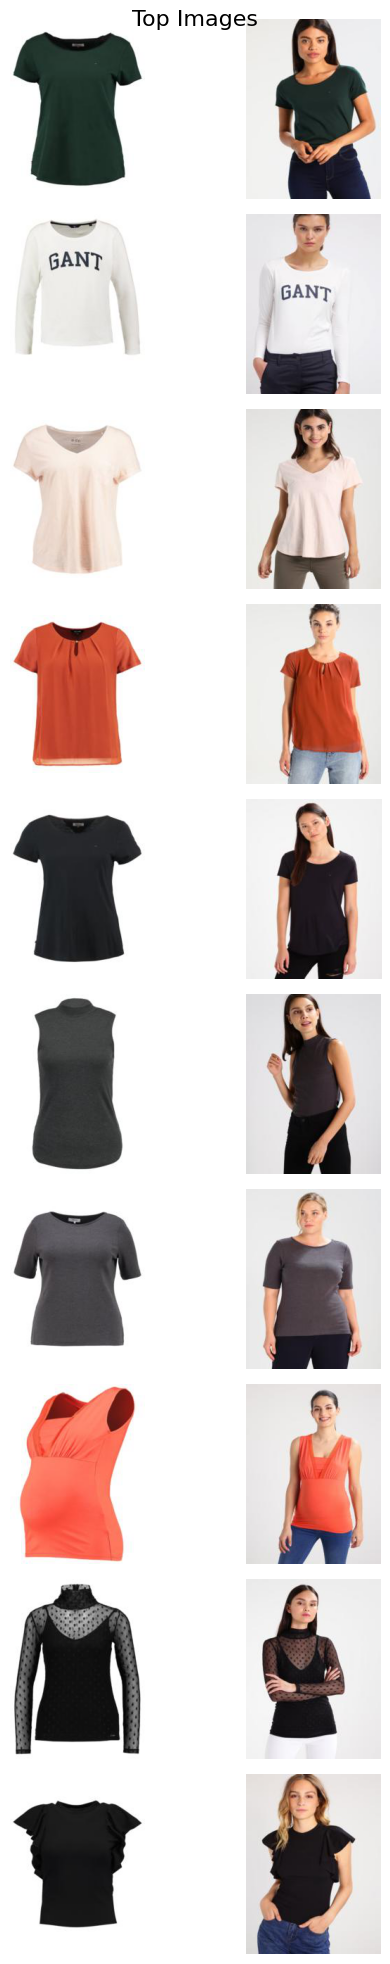

In [ ]:
fig, axs = plt.subplots(len(top_10_indices), 2, figsize=(6, 20))
num_images = len(top_10_indices)

# Plot the images from clothes_imgs in the first two columns
for i in range(num_images):

    axs[i,0].imshow(clothes_imgs[top_10_indices[i]])
    axs[i,0].axis('off')

# Plot the images from models_imgs in the last two columns
for i in range(num_images):
    axs[i,1].imshow(models_imgs[top_10_indices[i]])
    axs[i,1].axis('off')

plt.suptitle('Top Images', fontsize=16)

plt.tight_layout()

plt.show()

# Chapter III : Virtual Try-on. TryYours - High Resolution Virtual Try On site using HR-VITON.

In [ ]:
%cd TryYours-Virtual-Try-On

/content/TryYours-Virtual-Try-On


In [ ]:
import matplotlib.pyplot as plt
import cv2
#use this variable top_10_indices = np.argsort(my_correlation)[-10:]
# clothes_imgs[top_10_indices[i]] contains path of clothes of images

## Display Images
fig, axes = plt.subplots(len(top_10_indices), 2, figsize=(6, 40))

original = cv2.cvtColor(cv2.imread("/content/extracted_person.jpg"), cv2.COLOR_BGR2RGB)
for i in range(len(top_10_indices)):
  axes[i,0].axis('off')
  axes[i,0].imshow(original)
  axes[i,1].axis('off')
  axes[i,1].imshow(clothes_imgs[top_10_indices[i]])
plt.tight_layout()
#plt.suptitle('Let me dress u those outfit (recommended by the ai system)', fontsize=16)
plt.show()

In [ ]:
%cd /content/TryYours-Virtual-Try-On
!mkdir ./tryonclothesrecommended/
cpt=0
for i in range(len(top_10_indices)):
  cpt=cpt+1
  cv2.imwrite("./tryonclothesrecommended/test_"+str(cpt)+".jpg", clothes_imgs[top_10_indices[i]])

/content/TryYours-Virtual-Try-On
mkdir: cannot create directory ‘./tryonclothesrecommended/’: File exists


In [ ]:
%cd /content/TryYours-Virtual-Try-On

import os, sys
import cv2
from PIL import Image
import numpy as np
import glob
import warnings
import argparse
from cloths_segmentation.pre_trained_models import create_model



cmpt=0 #compteur image
# Read input image person

img=cv2.imread("/content/runs/detect/predict/crops/person/input.jpg")
ori_img=cv2.resize(img,(768,1024))
cv2.imwrite("./origin.jpg",ori_img)
# Resize input image
img=cv2.imread('origin.jpg')
img=cv2.resize(img,(384,512))
cv2.imwrite('resized_img.jpg',img)
!mkdir ./results_tryon/
for i in range(4): #len(top_10_indices)
  cmpt= cmpt + 1

  # Read input clothes recommended
  img=cv2.imread("./tryonclothesrecommended/test_"+str(cmpt)+".jpg")
  ori_img_1=cv2.resize(img,(768,1024))
  cv2.imwrite("./static/cloth_web.jpg",ori_img_1)

  # Get mask of cloth
  print("Get mask of cloth\n")
  terminnal_command = "python get_cloth_mask.py"
  os.system(terminnal_command)

  # Get openpose coordinate using posenet
  print("Get openpose coordinate using posenet\n")
  terminnal_command = "python posenet.py"
  os.system(terminnal_command)

  # Generate semantic segmentation using Graphonomy-Master library
  print("Generate semantic segmentation using Graphonomy-Master library\n")
  os.chdir("./Graphonomy-master")
  terminnal_command ="python exp/inference/inference.py --loadmodel ./inference.pth --img_path ../resized_img.jpg --output_path ../ --output_name /resized_segmentation_img"
  os.system(terminnal_command)
  os.chdir("../")

  # Remove background image using semantic segmentation mask
  mask_img=cv2.imread('./resized_segmentation_img.png',cv2.IMREAD_GRAYSCALE)
  mask_img=cv2.resize(mask_img,(768,1024))
  k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  mask_img = cv2.erode(mask_img, k)
  img_seg=cv2.bitwise_and(ori_img,ori_img,mask=mask_img)
  back_ground=ori_img-img_seg
  img_seg=np.where(img_seg==0,215,img_seg)
  cv2.imwrite("./seg_img.png",img_seg)
  img=cv2.resize(img_seg,(768,1024))
  cv2.imwrite('./HR-VITON-main/test/test/image/00001_00.jpg',img)

  # Generate grayscale semantic segmentation image
  terminnal_command ="python get_seg_grayscale.py"
  os.system(terminnal_command)

  # Generate Densepose image using detectron2 library
  print("\nGenerate Densepose image using detectron2 library\n")
  terminnal_command ="python detectron2/projects/DensePose/apply_net.py dump detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml \
  https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
  origin.jpg --output output.pkl -v"
  os.system(terminnal_command)
  terminnal_command ="python get_densepose.py"
  os.system(terminnal_command)

  # Run HR-VITON to generate final image
  print("\nRun HR-VITON to generate final image\n")
  os.chdir("./HR-VITON-main")
  terminnal_command = "python3 test_generator.py --cuda True --test_name test1 --tocg_checkpoint mtviton.pth --gpu_ids 0 --gen_checkpoint gen.pth --datasetting unpaired --data_list t2.txt --dataroot ./test"
  os.system(terminnal_command)
  # Add Background or Not
  l=glob.glob("./Output/*.png")
  background=True
  if background:
        for i in l:
            img=cv2.imread(i)
            img=cv2.bitwise_and(img,img,mask=mask_img)
            img=img+back_ground
            cv2.imwrite(i,img)

    # Remove Background
  else:
        for i in l:
            img=cv2.imread(i)
            cv2.imwrite(i,img)
  os.chdir("../")
  cv2.imwrite("./results_tryon/finalimg_"+str(cmpt)+".jpg", img)

/content/TryYours-Virtual-Try-On
mkdir: cannot create directory ‘./results_tryon/’: File exists
Get mask of cloth

Get openpose coordinate using posenet

Generate semantic segmentation using Graphonomy-Master library


Generate Densepose image using detectron2 library


Run HR-VITON to generate final image

Get mask of cloth

Get openpose coordinate using posenet

Generate semantic segmentation using Graphonomy-Master library


Generate Densepose image using detectron2 library


Run HR-VITON to generate final image

Get mask of cloth

Get openpose coordinate using posenet

Generate semantic segmentation using Graphonomy-Master library


Generate Densepose image using detectron2 library


Run HR-VITON to generate final image

Get mask of cloth

Get openpose coordinate using posenet

Generate semantic segmentation using Graphonomy-Master library


Generate Densepose image using detectron2 library


Run HR-VITON to generate final image



In [ ]:
folder_path = "./results_tryon"  # Replace with the path to your folder containing images

# Get a list of image file names in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith((".png", ".jpg", ".jpeg"))]

# Loop through the image files and display each one
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)
    display(image)

# Chapter IV : Recommendation system II ( Pyaesthetics...)

In [ ]:
pip install pyaesthetics

In [ ]:
#load only the neede functions from the specific module
from pyaesthetics.brightness import relativeLuminance_BT601, sRGB2RGB
import cv2 #to open and handle images

img = "/content/TryYours-Virtual-Try-On/results_tryon/finalimg_4.jpg" #path to a sample image

img = cv2.imread(img) #load the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert to the RGB colorscheme
img = sRGB2RGB(img) #convert pixels to their linear RGB values
print(relativeLuminance_BT601(img)) #evaluate luminance on the BT601 standard

0.2801352064960986


In [ ]:
# Directory containing the images
image_directory = "/content/TryYours-Virtual-Try-On/results_tryon/"  # Replace with the actual directory path

# Pattern for image file extensions (you can add more extensions if needed)
image_pattern = "*.jpg"

# Get a list of image file paths using glob
image_paths = glob.glob(f"{image_directory}/{image_pattern}")
best_outfit=[]
# Loop through each image path and perform analysis
for img_path in image_paths:
    img = cv2.imread(img_path) #load the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert to the RGB colorscheme
    img = sRGB2RGB(img) #convert pixels to their linear RGB values
    relativeLuminance_BT601(img)
    best_outfit.append(relativeLuminance_BT601(img))
# Find the index of the maximum value in the list
max_index = best_outfit.index(max(best_outfit))
image = Image.open("/content/TryYours-Virtual-Try-On/results_tryon/finalimg_"+str(max_index)+".jpg")
display("best outfit recommended by the Ai system")
display(image)